Importing Dataset from Kaggle:

[Dataset Link](https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive)

In [ ]:
!pip install -q kaggle
from google.colab import files

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download 'hgultekin/bbcnewsarchive'

  0% 0.00/1.81M [00:00<?, ?B/s]
100% 1.81M/1.81M [00:00<00:00, 49.9MB/s]


In [ ]:
! mkdir train

In [ ]:
! unzip bbcnewsarchive.zip -d train

Archive:  bbcnewsarchive.zip
  inflating: train/bbc-news-data.csv  


Importing packages

In [ ]:
import pandas as pd
import nltk
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from gensim.models import Word2Vec
import gensim.downloader as api

import en_core_web_sm
from tqdm import tqdm
import spacy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df=pd.read_csv('/content/train/bbc-news-data.csv', sep='\t')
df = df.dropna()
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [ ]:
data = df['content']
data.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2225 entries, 0 to 2224
Series name: content
Non-Null Count  Dtype 
--------------  ----- 
2225 non-null   object
dtypes: object(1)
memory usage: 17.5+ KB


TF-IDF

In [ ]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
preprocessed_data = [" ".join([word for word in article.split() if word.lower() not in stop_words]) for article in data]

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(preprocessed_data)

# K-Means Clustering
k =  5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_tfidf)

# Assign clusters to the original data
clusters_tfidf = kmeans.labels_

# Create a DataFrame with the original data and the assigned clusters
df = pd.DataFrame({'Text': data, 'Cluster': clusters_tfidf})

# Print the documents in each cluster
# for cluster_id in range(k):
#     print(f"\nCluster {cluster_id}:\n")
#     print(df[df['Cluster'] == cluster_id]['Text'].head())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


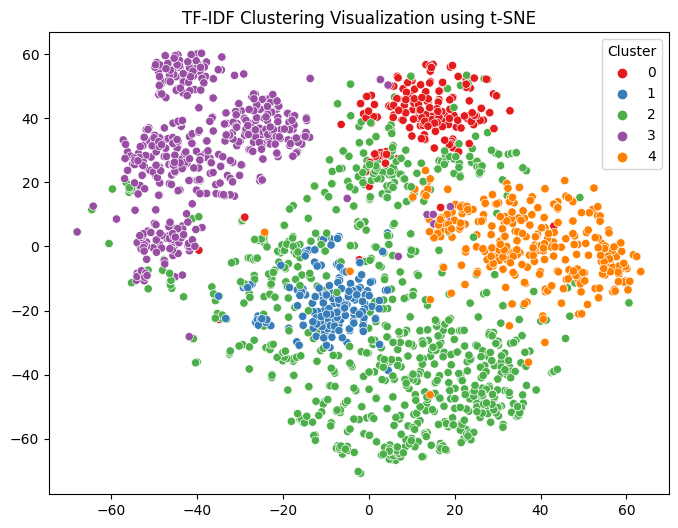

In [ ]:
# Perform t-SNE dimensionality reduction
X_tsne_tfidf = TSNE(n_components=2, random_state=42).fit_transform(X_tfidf.toarray())

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_tsne_tfidf[:, 0],
    y=X_tsne_tfidf[:, 1],
    hue=clusters_tfidf,
    palette='Set1',
    legend='full'
)
plt.title('TF-IDF Clustering Visualization using t-SNE')
plt.legend(title='Cluster')
plt.show()


In [ ]:
db_index = davies_bouldin_score(X_tfidf.toarray(), clusters_tfidf)
print(f"Davies-Bouldin Index: {db_index}")
ch_score = calinski_harabasz_score(X_tfidf.toarray(), clusters_tfidf)
print("Calinski-Harabasz Index:", ch_score)

Davies-Bouldin Index: 8.582721271749346
Calinski-Harabasz Index: 14.52589292320691


Word2Vec

In [ ]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
tokenized_data = [nltk.word_tokenize(article) for article in data]
preprocessed_data = [
    [word.lower() for word in article if word.lower() not in stop_words]
    for article in tokenized_data
]

In [ ]:
# Training Word2Vec Model
model = Word2Vec(preprocessed_data, vector_size=100, window=5, min_count=1, workers=4)
model.train(preprocessed_data, total_examples=len(preprocessed_data), epochs=10)

# Function to average word vectors for a document
def document_vector(words, model):
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return sum(word_vectors) / len(word_vectors)

# Get document vectors
document_vectors = [document_vector(article, model) for article in preprocessed_data]

# K-Means Clustering
k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(document_vectors)

# Assign clusters to the original data
clusters_word2vec = kmeans.labels_

# Create a DataFrame with the original data and the assigned clusters
df = pd.DataFrame({'Text': data, 'Cluster': clusters_word2vec})

# # Print the documents in each cluster
# for cluster_id in range(k):
#     print(f"\nCluster {cluster_id}:\n")
#     print(df[df['Cluster'] == cluster_id]['Text'].head())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
db_index = davies_bouldin_score(document_vectors, clusters_word2vec)
print(f"Davies-Bouldin Index: {db_index}")
ch_score = calinski_harabasz_score(document_vectors, clusters_word2vec)
print("Calinski-Harabasz Index:", ch_score)

Davies-Bouldin Index: 1.552198851451664
Calinski-Harabasz Index: 484.7779150015865


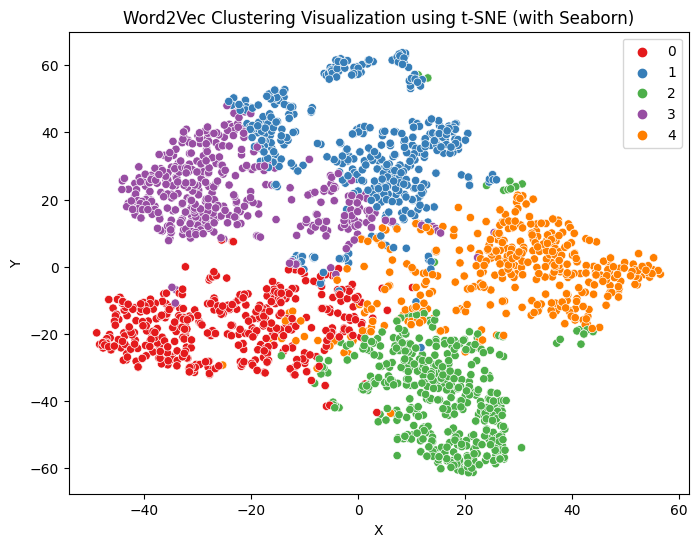

In [ ]:
# Reduce dimensionality for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42)
document_vectors_2d = tsne.fit_transform(np.array(document_vectors))

# Create a DataFrame with the 2D embeddings and the assigned clusters
df_tsne = pd.DataFrame({
    'X': document_vectors_2d[:, 0],
    'Y': document_vectors_2d[:, 1],
    'Cluster': clusters_word2vec
})

# Plot clusters using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='X', y='Y', hue='Cluster', data=df_tsne, palette='Set1', legend='full')
plt.title('Word2Vec Clustering Visualization using t-SNE (with Seaborn)')
plt.legend(loc='upper right')
plt.show()


GloVe

In [ ]:
# Load GloVe word vectors
word_vectors = api.load("glove-wiki-gigaword-100")

# Text Preprocessing
stop_words = set(stopwords.words('english'))
preprocessed_data = [
    [word for word in article.split() if word.lower() not in stop_words]
    for article in data
]

# Function to average word vectors for a document
def document_vector(words, model):
    word_vectors = [model[word] for word in words if word in model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

# Get document vectors using GloVe embeddings
document_vectors = [document_vector(article, word_vectors) for article in preprocessed_data]

# K-Means Clustering
k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(document_vectors)

# Assign clusters to the original data
clusters_glove = kmeans.labels_

# Create a DataFrame with the original data and the assigned clusters
df = pd.DataFrame({'Text': data, 'Cluster': clusters_glove})

# Print the documents in each cluster
# for cluster_id in range(k):
#     print(f"\nCluster {cluster_id}:\n")
#     print(df[df['Cluster'] == cluster_id]['Text'].head())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
db_index_glove = davies_bouldin_score(document_vectors, clusters_glove)
print(f"Davies-Bouldin index for GloVe-based clusters: {db_index_glove}")
ch_score_glove = calinski_harabasz_score(document_vectors, clusters_glove)
print("Calinski-Harabasz Index:", ch_score_glove)

Davies-Bouldin index for GloVe-based clusters: 1.7722612072390191
Calinski-Harabasz Index: 369.76520262377016


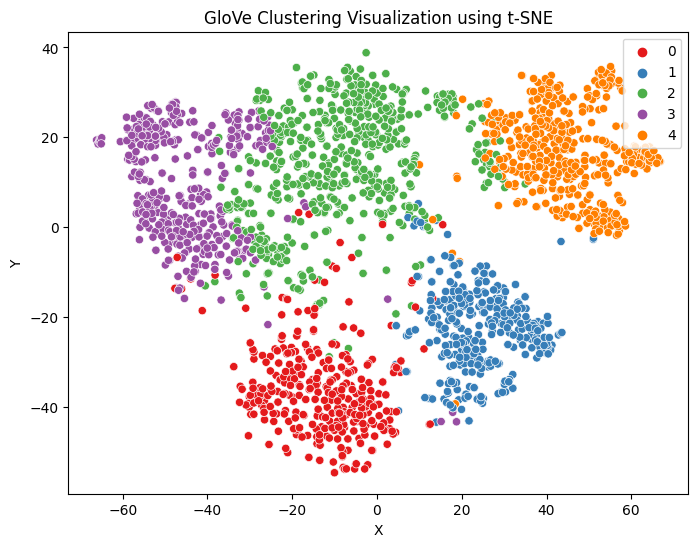

In [ ]:
# Reduce dimensionality for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42)
document_vectors_2d = tsne.fit_transform(np.array(document_vectors))

# Add cluster labels to DataFrame
df_tsne = pd.DataFrame({
    'X': document_vectors_2d[:, 0],
    'Y': document_vectors_2d[:, 1],
    'Cluster': clusters_glove
})

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='X', y='Y', hue='Cluster', data=df_tsne, palette='Set1', legend='full')
plt.title('GloVe Clustering Visualization using t-SNE')
plt.legend(loc='upper right')
plt.show()


In [ ]:
!pip install transformers

In [ ]:
from transformers import BertModel, BertTokenizer
import torch
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Extract the news content from the DataFrame
data = df['content'].tolist()

In [ ]:
# Define batch size
batch_size = 100  # Adjust according to your memory constraints

# Tokenize and encode the documents in batches using BERT tokenizer
embeddings = []
for i in range(0, len(data), batch_size):
    batch = data[i:i+batch_size]
    tokenized_batch = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)

    # Get BERT embeddings for the batch
    with torch.no_grad():
        outputs = model(**tokenized_batch)
    batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Using [CLS] token for document representation
    embeddings.append(batch_embeddings)

# Concatenate embeddings from batches
embeddings = np.concatenate(embeddings, axis=0)

In [ ]:
# Perform clustering (using KMeans as an example)
k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(embeddings)

# Assign clusters to the original data
clusters_bert = kmeans.labels_

# Create DataFrame with the original data and assigned clusters
df_bert = pd.DataFrame({'Text': data, 'Cluster': clusters_bert})

# # Print documents in each cluster
# for cluster_id in range(k):
#     print(f"\nCluster {cluster_id}:\n")
#     print(df_bert[df_bert['Cluster'] == cluster_id]['Text'].head())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
db_index_bert = davies_bouldin_score(embeddings, clusters_bert)
print(f"Davies-Bouldin index for BERT-based clusters: {db_index_bert}")
ch_score_bert = calinski_harabasz_score(embeddings, clusters_bert)
print("Calinski-Harabasz Index:", ch_score_bert)

Davies-Bouldin index for BERT-based clusters: 3.0890269704995594
Calinski-Harabasz Index: 125.49432997001588


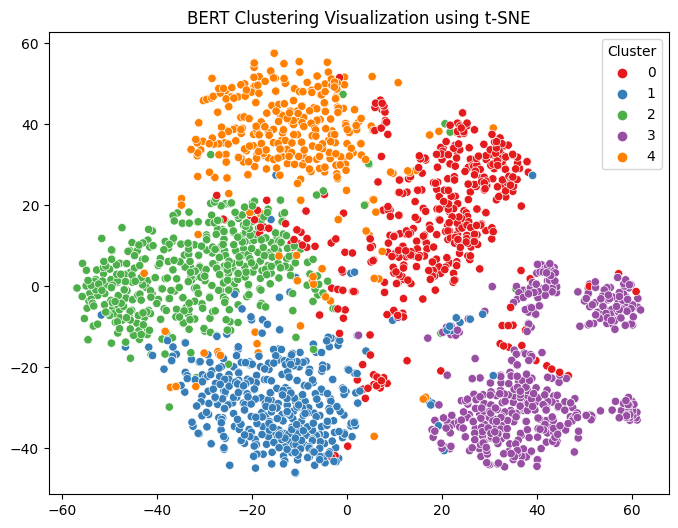

In [ ]:
# Perform t-SNE dimensionality reduction on BERT embeddings
X_tsne_bert = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

# Visualize the t-SNE projections with BERT clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_tsne_bert[:, 0],
    y=X_tsne_bert[:, 1],
    hue=clusters_bert,
    palette='Set1',
    legend='full'
)
plt.title('BERT Clustering Visualization using t-SNE')
plt.legend(title='Cluster')
plt.show()
